### Αν και τα αποτελέσματα πρέπει να εμφανίζονται παρακάτω, σε περίπτωση που δεν, παρακαλώ επισκευτείτε αυτό το [link](https://drive.google.com/drive/folders/1UhkzpJmkRdwSGK4JMMD0nEc9oR4vUI60?usp=sharing) ώστε να το ανοίξετε στο google collab. Έχω δώσει read/write δικαιώματα στο συγκεκριμένο link, οπότε με ενα double click στο rcnn.ipynb πρέπει να ανοίγει. Ωστόσο αν υπάρχει το παραμικρό πρόβλημα, παρακαλώ επικοινωνήστε μαζί μου στο up1084537@ac.upatras.gr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title DO NOT RUN
!cp -r '/content/drive/MyDrive/CV_6-CNN' '/content/drive/MyDrive/copy_CV_6-CNN'

cp: cannot create symbolic link '/content/drive/MyDrive/copy_CV_6-CNN/CV_6-CNN': Read-only file system


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams['image.cmap'] = 'gist_gray'
from torch.utils.data import DataLoader
from torchvision import models
from torchvision import transforms
from matplotlib.patches import Rectangle
from torchvision.datasets import CocoDetection
device = torch.device('cuda:0')

Dataset

In [ ]:
dataset_val = CocoDetection(root='/content/drive/MyDrive/CV_6-CNN/val2017/',
                            annFile='/content/drive/MyDrive/CV_6-CNN/annotations_trainval2017/annotations/instances_val2017.json',
                            transform=transforms.Compose([transforms.ToTensor(),transforms.Resize((320,213))]))


loading annotations into memory...
Done (t=2.46s)
creating index...
index created!


Dataloader

In [ ]:
val_dataloader = DataLoader(dataset_val, batch_size=1, shuffle=False, num_workers=0)

# SSD with VGG16 backbone CNN

In [ ]:
model = models.detection.ssd300_vgg16(pretrained=True,num_classes=91).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SSD300_VGG16_Weights.COCO_V1`. You can also use `weights=SSD300_VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/ssd300_vgg16_coco-b556d3b4.pth" to /root/.cache/torch/hub/checkpoints/ssd300_vgg16_coco-b556d3b4.pth
100%|██████████| 136M/136M [00:01<00:00, 89.5MB/s]


ALREADY RAN, THE RESULTS ARE ALREADY SAVED IN THE DRAVE UNDER /all_detections_ssd and /all_targets_ssd

In [ ]:
from tqdm import tqdm # fancy and unnecessary library to add loading bar for the loop

model.eval() # switch to evaluation mode,

all_detections = []
all_targets = []
for imgs_batch,targets_batch in tqdm(val_dataloader):
    # Move imgs_batch and targets_batch to device
    imgs_batch = [imgs.to(device) for imgs in imgs_batch]

    targets_batch = [targets for targets in targets_batch]

    # Transform targets to COCO format.
    new_targets_batch = []
    targets_batch = [targets_batch]

    for targets in targets_batch:
        new_targets = {'boxes':[],'labels':[]}
        for t in targets:
            x,y,w,h = [s for s in t['bbox']]
            new_targets['boxes'].append(torch.Tensor([x, y, x+w, y+h]))
            new_targets['labels'].append(t['category_id'])
        if len(new_targets['boxes']) > 0:
            new_targets['boxes'] = torch.stack(new_targets['boxes'], dim=0)
        new_targets['labels'] = torch.Tensor(new_targets['labels']).long()
        new_targets_batch.append(new_targets)
    targets_batch = new_targets_batch

    # Forward pass
    with torch.no_grad():
        detections_batch = model(imgs_batch)

    del imgs_batch


    # Keep detections and targets to compare
    all_targets.append(targets_batch)
    all_detections.append(detections_batch)

torch.save(all_detections, '/content/drive/MyDrive/CV_6-CNN/all_detections_ssd.pth')
torch.save(all_targets,'/content/drive/MyDrive/CV_6-CNN/all_targets_ssd.pth')

100%|██████████| 5000/5000 [30:26<00:00,  2.74it/s]


## Precision, Recall, F1 score (SSD)

### Load results for SSD

In [ ]:
# Load saved detections and targets
detections = torch.load('/content/drive/MyDrive/CV_6-CNN/all_detections_ssd.pth')
targets = torch.load('/content/drive/MyDrive/CV_6-CNN/all_targets_ssd.pth')

<ipython-input-6-76098310079e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detections = torch.load('/content/drive/MyDrive/CV_6-CNN/all_detections_ssd.pth')
<ipython-in

In [ ]:
# Evaluation Functions
import torch
import numpy as np
from tqdm import tqdm

def calculate_iou(box1, box2):
    """Calculate IoU between two boxes"""
    # Convert boxes to correct format if needed
    if len(box1) == 4:
        box1_x1, box1_y1 = box1[0], box1[1]
        box1_x2, box1_y2 = box1[0] + box1[2], box1[1] + box1[3]
    else:
        box1_x1, box1_y1, box1_x2, box1_y2 = box1

    if len(box2) == 4:
        box2_x1, box2_y1 = box2[0], box2[1]
        box2_x2, box2_y2 = box2[0] + box2[2], box2[1] + box2[3]
    else:
        box2_x1, box2_y1, box2_x2, box2_y2 = box2

    # Calculate intersection coordinates
    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)

    # Calculate areas
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0

def evaluate_detections(detections, targets, iou_threshold=0.5, conf_threshold=0.5):
    """
    Evaluate object detections against ground truth targets
    """
    true_positives = []
    false_positives = []
    total_gt = 0

    # Process each image
    for img_dets, img_targets in tqdm(zip(detections, targets)):
        if len(img_dets) == 0 or len(img_targets) == 0:
            continue

        # Get detection boxes and scores
        det_boxes = img_dets[0]['boxes']
        det_scores = img_dets[0]['scores']
        det_labels = img_dets[0]['labels']

        # Filter by confidence
        mask = det_scores > conf_threshold
        det_boxes = det_boxes[mask]
        det_scores = det_scores[mask]
        det_labels = det_labels[mask]

        # Get target boxes and labels - they're already in the correct format
        target_boxes = img_targets[0]['boxes']
        target_labels = img_targets[0]['labels']

        total_gt += len(target_boxes)

        # Match detections to ground truth
        matched_targets = set()  # Keep track of matched targets

        for det_box, det_score, det_label in zip(det_boxes, det_scores, det_labels):
            max_iou = 0
            max_idx = -1

            # Compare with each target box
            for i, target_box in enumerate(target_boxes):
                if i in matched_targets:
                    continue

                if target_labels[i] != det_label:
                    continue

                iou = calculate_iou(det_box.cpu(), target_box.cpu())
                if iou > max_iou:
                    max_iou = iou
                    max_idx = i

            if max_iou >= iou_threshold:
                true_positives.append(det_score.cpu().item())
                matched_targets.add(max_idx)
            else:
                false_positives.append(det_score.cpu().item())

    # Calculate metrics
    true_positives = np.array(sorted(true_positives, reverse=True))
    false_positives = np.array(sorted(false_positives, reverse=True))

    # Calculate final metrics
    if len(true_positives) + len(false_positives) > 0:
        precision = len(true_positives) / (len(true_positives) + len(false_positives))
    else:
        precision = 0

    if total_gt > 0:
        recall = len(true_positives) / total_gt
    else:
        recall = 0

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

In [ ]:
# Visualization Functions
import matplotlib.pyplot as plt

def calculate_pr_points(detections, targets, iou_threshold=0.5):
    """Calculate precision and recall points for plotting"""
    tp = []
    scores = []
    num_gt = 0

    for img_dets, img_targets in zip(detections, targets):
        if len(img_dets) == 0 or len(img_targets) == 0:
            continue

        det_boxes = img_dets[0]['boxes']
        det_scores = img_dets[0]['scores']
        det_labels = img_dets[0]['labels']

        target_boxes = img_targets[0]['boxes']
        target_labels = img_targets[0]['labels']

        num_gt += len(target_boxes)

        matched_targets = set()

        for det_box, score, det_label in zip(det_boxes, det_scores, det_labels):
            max_iou = 0
            max_idx = -1

            for i, target_box in enumerate(target_boxes):
                if i in matched_targets:
                    continue

                if target_labels[i] != det_label:
                    continue

                iou = calculate_iou(det_box.cpu(), target_box.cpu())
                if iou > max_iou:
                    max_iou = iou
                    max_idx = i

            if max_iou >= iou_threshold and max_idx not in matched_targets:
                tp.append(1)
                matched_targets.add(max_idx)
            else:
                tp.append(0)
            scores.append(score.cpu().item())

    if len(tp) == 0:
        return np.array([]), np.array([])

    # Sort by confidence
    indices = np.argsort(scores)[::-1]
    tp = np.array(tp)[indices]

    # Calculate cumulative precisions and recalls
    tp_cumsum = np.cumsum(tp)
    precisions = tp_cumsum / np.arange(1, len(tp) + 1)
    recalls = tp_cumsum / num_gt if num_gt > 0 else np.zeros_like(tp_cumsum)

    return precisions, recalls

def plot_pr_curve(precisions, recalls, model_name):
    plt.plot(recalls, precisions, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend()

In [ ]:
def calculate_map(detections, targets, iou_threshold=0.5, num_recall_points=11):
    """
    Calculate Mean Average Precision
    """
    # Store APs for each class
    class_aps = {}

    # Get all unique classes from targets
    all_classes = set()
    for img_targets in targets:
        if len(img_targets) > 0:
            all_classes.update(img_targets[0]['labels'].cpu().numpy())

    # Calculate AP for each class
    for class_id in all_classes:
        tp = []
        scores = []
        num_gt = 0

        # Process each image
        for img_dets, img_targets in zip(detections, targets):
            if len(img_dets) == 0 or len(img_targets) == 0:
                continue

            # Get detections for this class
            det_boxes = img_dets[0]['boxes']
            det_scores = img_dets[0]['scores']
            det_labels = img_dets[0]['labels']

            # Filter detections by class
            class_mask = det_labels == class_id
            det_boxes = det_boxes[class_mask]
            det_scores = det_scores[class_mask]

            # Get ground truth for this class
            target_boxes = img_targets[0]['boxes']
            target_labels = img_targets[0]['labels']

            # Filter ground truth boxes by class
            target_mask = target_labels == class_id
            if target_mask.any():
                target_boxes = target_boxes[target_mask]
                num_gt += len(target_boxes)
            else:
                continue

            if len(det_boxes) == 0:
                continue

            # Match detections to ground truth
            matched_gt = set()

            for det_box, score in zip(det_boxes, det_scores):
                max_iou = 0
                max_idx = -1

                for i, target_box in enumerate(target_boxes):
                    if i in matched_gt:
                        continue

                    iou = calculate_iou(det_box.cpu(), target_box.cpu())
                    if iou > max_iou:
                        max_iou = iou
                        max_idx = i

                if max_iou >= iou_threshold and max_idx not in matched_gt:
                    tp.append(1)
                    matched_gt.add(max_idx)
                else:
                    tp.append(0)
                scores.append(score.cpu().item())

        if len(tp) == 0 or num_gt == 0:
            class_aps[class_id] = 0
            continue

        # Convert to numpy arrays
        tp = np.array(tp)
        scores = np.array(scores)

        # Sort by confidence
        indices = np.argsort(scores)[::-1]
        tp = tp[indices]

        # Compute precision and recall
        cumsum = np.cumsum(tp)
        precisions = cumsum / np.arange(1, len(tp) + 1)
        recalls = cumsum / num_gt

        # Compute AP using 11-point interpolation
        ap = 0
        for recall_threshold in np.linspace(0, 1, num_recall_points):
            precision_values = precisions[recalls >= recall_threshold]
            if len(precision_values) > 0:
                ap += np.max(precision_values)
        ap /= num_recall_points

        class_aps[class_id] = ap

    # Calculate mAP
    mean_ap = np.mean(list(class_aps.values()))

    return mean_ap, class_aps

# Calculate mAP
print("Calculating mAP...")
mean_ap, class_aps = calculate_map(detections, targets)
print(f"\nMean Average Precision (mAP): {mean_ap:.4f}")

# Print AP for each class
print("\nAverage Precision per class:")
for class_id, ap in sorted(class_aps.items()):
    print(f"Class {class_id}: {ap:.4f}")

Calculating mAP...

Mean Average Precision (mAP): 0.0076

Average Precision per class:
Class 1: 0.0110
Class 2: 0.0091
Class 3: 0.0236
Class 4: 0.0089
Class 5: 0.0023
Class 6: 0.0012
Class 7: 0.0005
Class 8: 0.0020
Class 9: 0.0103
Class 10: 0.0027
Class 11: 0.0007
Class 13: 0.0015
Class 14: 0.0011
Class 15: 0.0022
Class 16: 0.0042
Class 17: 0.0021
Class 18: 0.0010
Class 19: 0.0061
Class 20: 0.0159
Class 21: 0.0099
Class 22: 0.0201
Class 23: 0.0114
Class 24: 0.0228
Class 25: 0.0054
Class 27: 0.0227
Class 28: 0.0053
Class 31: 0.0057
Class 32: 0.0022
Class 33: 0.0909
Class 34: 0.0006
Class 35: 0.0028
Class 36: 0.0057
Class 37: 0.0006
Class 38: 0.0089
Class 39: 0.0018
Class 40: 0.0152
Class 41: 0.0014
Class 42: 0.0024
Class 43: 0.0051
Class 44: 0.0072
Class 46: 0.0052
Class 47: 0.0020
Class 48: 0.0130
Class 49: 0.0028
Class 50: 0.0006
Class 51: 0.0040
Class 52: 0.0057
Class 53: 0.0067
Class 54: 0.0038
Class 55: 0.0043
Class 56: 0.0076
Class 57: 0.0057
Class 58: 0.0455
Class 59: 0.0033
Clas

Evaluating SSD...


5000it [00:13, 383.74it/s]



SSD Results:
Precision: 0.0485
Recall: 0.0133
F1 Score: 0.0209


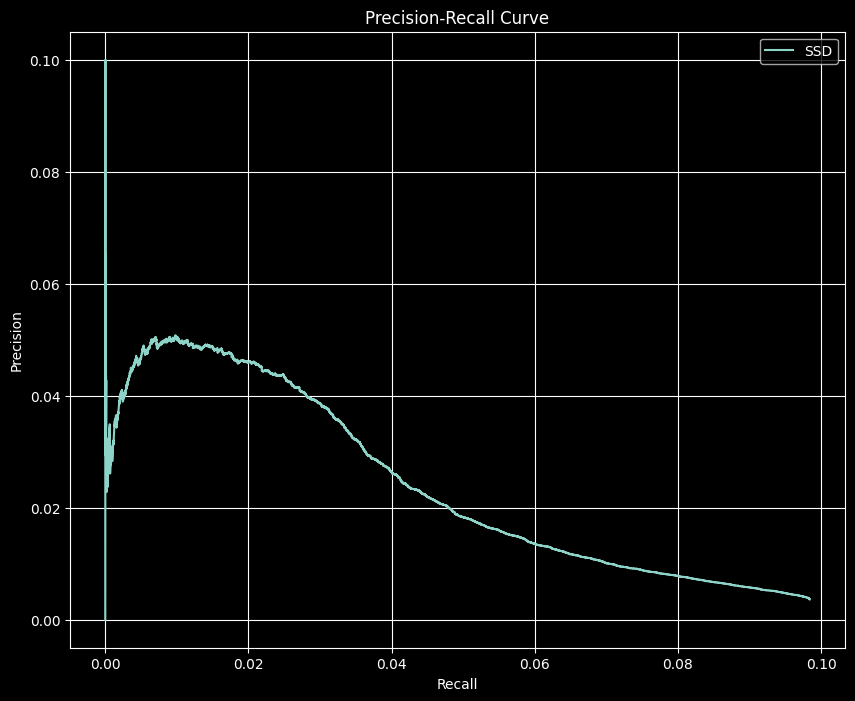

In [ ]:
# Evaluate SSD
print("Evaluating SSD...")
precision_ssd, recall_ssd, f1_ssd = evaluate_detections(detections, targets)

print(f"\nSSD Results:")
print(f"Precision: {precision_ssd:.4f}")
print(f"Recall: {recall_ssd:.4f}")
print(f"F1 Score: {f1_ssd:.4f}")

# Plot PR curve
plt.figure(figsize=(10, 8))
precisions_ssd, recalls_ssd = calculate_pr_points(detections, targets)
plot_pr_curve(precisions_ssd, recalls_ssd, 'SSD')
plt.show()

# Faster-RCNN with ResNet50 backbone CNN and FPN

In [ ]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True,num_classes=91).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 153MB/s]


ALREADY RAN, THE RESULTS ARE ALREADY SAVED IN THE DRAVE UNDER /all_detections_faster and /all_targets_faster

In [ ]:
from tqdm import tqdm # fancy and unnecessary library to add loading bar for the loop

model.eval() # switch to evaluation mode,

all_detections = []
all_targets = []
for imgs_batch,targets_batch in tqdm(val_dataloader):
    # Move imgs_batch and targets_batch to device
    imgs_batch = [imgs.to(device) for imgs in imgs_batch]

    targets_batch = [targets for targets in targets_batch]

    # Transform targets to COCO format.
    new_targets_batch = []
    targets_batch = [targets_batch]

    for targets in targets_batch:
        new_targets = {'boxes':[],'labels':[]}
        for t in targets:
            x,y,w,h = [s for s in t['bbox']]
            new_targets['boxes'].append(torch.Tensor([x, y, x+w, y+h]))
            new_targets['labels'].append(t['category_id'])
        if len(new_targets['boxes']) > 0:
            new_targets['boxes'] = torch.stack(new_targets['boxes'], dim=0)
        new_targets['labels'] = torch.Tensor(new_targets['labels']).long()
        new_targets_batch.append(new_targets)
    targets_batch = new_targets_batch

    # Forward pass
    with torch.no_grad():
        detections_batch = model(imgs_batch)

    del imgs_batch


    # Keep detections and targets to compare
    all_targets.append(targets_batch)
    all_detections.append(detections_batch)

torch.save(all_detections, '/content/drive/MyDrive/CV_6-CNN/all_detections_faster.pth')
torch.save(all_targets,'/content/drive/MyDrive/CV_6-CNN/all_targets_faster.pth')

100%|██████████| 5000/5000 [1:11:42<00:00,  1.16it/s]


## Precision, Recall, F1 score, Mean Average Precision (FASTER RCNN)

### Load results for faster rcnn

In [ ]:
# Load saved detections and targets
detections = torch.load('/content/drive/MyDrive/CV_6-CNN/all_detections_faster.pth')
targets = torch.load('/content/drive/MyDrive/CV_6-CNN/all_targets_faster.pth')


<ipython-input-10-a609deb1d4a9>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detections = torch.load('/content/drive/MyDrive/CV_6-CNN/all_detections_faster.pth')
<ipytho

In [ ]:
# Evaluation Functions
import torch
import numpy as np
from tqdm import tqdm

def calculate_iou(box1, box2):
    """Calculate IoU between two boxes"""
    # Convert boxes to correct format if needed
    if len(box1) == 4:
        box1_x1, box1_y1 = box1[0], box1[1]
        box1_x2, box1_y2 = box1[0] + box1[2], box1[1] + box1[3]
    else:
        box1_x1, box1_y1, box1_x2, box1_y2 = box1

    if len(box2) == 4:
        box2_x1, box2_y1 = box2[0], box2[1]
        box2_x2, box2_y2 = box2[0] + box2[2], box2[1] + box2[3]
    else:
        box2_x1, box2_y1, box2_x2, box2_y2 = box2

    # Calculate intersection coordinates
    x1 = max(box1_x1, box2_x1)
    y1 = max(box1_y1, box2_y1)
    x2 = min(box1_x2, box2_x2)
    y2 = min(box1_y2, box2_y2)

    # Calculate areas
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union = box1_area + box2_area - intersection

    return intersection / union if union > 0 else 0

def evaluate_detections(detections, targets, iou_threshold=0.5, conf_threshold=0.5):
    """
    Evaluate object detections against ground truth targets
    """
    true_positives = []
    false_positives = []
    total_gt = 0

    # Process each image
    for img_dets, img_targets in tqdm(zip(detections, targets)):
        if len(img_dets) == 0 or len(img_targets) == 0:
            continue

        # Get detection boxes and scores
        det_boxes = img_dets[0]['boxes']
        det_scores = img_dets[0]['scores']
        det_labels = img_dets[0]['labels']

        # Filter by confidence
        mask = det_scores > conf_threshold
        det_boxes = det_boxes[mask]
        det_scores = det_scores[mask]
        det_labels = det_labels[mask]

        # Get target boxes and labels - they're already in the correct format
        target_boxes = img_targets[0]['boxes']
        target_labels = img_targets[0]['labels']

        total_gt += len(target_boxes)

        # Match detections to ground truth
        matched_targets = set()  # Keep track of matched targets

        for det_box, det_score, det_label in zip(det_boxes, det_scores, det_labels):
            max_iou = 0
            max_idx = -1

            # Compare with each target box
            for i, target_box in enumerate(target_boxes):
                if i in matched_targets:
                    continue  # Skip already matched targets

                if target_labels[i] != det_label:
                    continue

                iou = calculate_iou(det_box.cpu(), target_box.cpu())
                if iou > max_iou:
                    max_iou = iou
                    max_idx = i

            if max_iou >= iou_threshold:
                true_positives.append(det_score.cpu().item())
                matched_targets.add(max_idx)
            else:
                false_positives.append(det_score.cpu().item())

    # Calculate metrics
    true_positives = np.array(sorted(true_positives, reverse=True))
    false_positives = np.array(sorted(false_positives, reverse=True))

    # Calculate final metrics
    if len(true_positives) + len(false_positives) > 0:
        precision = len(true_positives) / (len(true_positives) + len(false_positives))
    else:
        precision = 0

    if total_gt > 0:
        recall = len(true_positives) / total_gt
    else:
        recall = 0

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1

In [ ]:
# Visualization Functions
import matplotlib.pyplot as plt

def calculate_pr_points(detections, targets, iou_threshold=0.5):
    """Calculate precision and recall points for plotting"""
    tp = []
    scores = []
    num_gt = 0

    for img_dets, img_targets in zip(detections, targets):
        if len(img_dets) == 0 or len(img_targets) == 0:
            continue

        det_boxes = img_dets[0]['boxes']
        det_scores = img_dets[0]['scores']
        det_labels = img_dets[0]['labels']

        target_boxes = img_targets[0]['boxes']
        target_labels = img_targets[0]['labels']

        num_gt += len(target_boxes)

        matched_targets = set()

        for det_box, score, det_label in zip(det_boxes, det_scores, det_labels):
            max_iou = 0
            max_idx = -1

            for i, target_box in enumerate(target_boxes):
                if i in matched_targets:
                    continue

                if target_labels[i] != det_label:
                    continue

                iou = calculate_iou(det_box.cpu(), target_box.cpu())
                if iou > max_iou:
                    max_iou = iou
                    max_idx = i

            if max_iou >= iou_threshold and max_idx not in matched_targets:
                tp.append(1)
                matched_targets.add(max_idx)
            else:
                tp.append(0)
            scores.append(score.cpu().item())

    if len(tp) == 0:
        return np.array([]), np.array([])

    # Sort by confidence
    indices = np.argsort(scores)[::-1]
    tp = np.array(tp)[indices]

    # Calculate cumulative precisions and recalls
    tp_cumsum = np.cumsum(tp)
    precisions = tp_cumsum / np.arange(1, len(tp) + 1)
    recalls = tp_cumsum / num_gt if num_gt > 0 else np.zeros_like(tp_cumsum)

    return precisions, recalls

def plot_pr_curve(precisions, recalls, model_name):
    plt.plot(recalls, precisions, label=model_name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.grid(True)
    plt.legend()

In [ ]:
def calculate_map(detections, targets, iou_threshold=0.5, num_recall_points=11):
    """
    Calculate Mean Average Precision
    """
    # Store APs for each class
    class_aps = {}

    # Get all unique classes from targets
    all_classes = set()
    for img_targets in targets:
        if len(img_targets) > 0:
            all_classes.update(img_targets[0]['labels'].cpu().numpy())

    # Calculate AP for each class
    for class_id in all_classes:
        tp = []
        scores = []
        num_gt = 0

        # Process each image
        for img_dets, img_targets in zip(detections, targets):
            if len(img_dets) == 0 or len(img_targets) == 0:
                continue

            # Get detections for this class
            det_boxes = img_dets[0]['boxes']
            det_scores = img_dets[0]['scores']
            det_labels = img_dets[0]['labels']

            # Filter detections by class
            class_mask = det_labels == class_id
            det_boxes = det_boxes[class_mask]
            det_scores = det_scores[class_mask]

            # Get ground truth for this class
            target_boxes = img_targets[0]['boxes']
            target_labels = img_targets[0]['labels']

            # Filter ground truth boxes by class
            target_mask = target_labels == class_id
            if target_mask.any():
                target_boxes = target_boxes[target_mask]
                num_gt += len(target_boxes)
            else:
                continue

            if len(det_boxes) == 0:
                continue

            # Match detections to ground truth
            matched_gt = set()

            for det_box, score in zip(det_boxes, det_scores):
                max_iou = 0
                max_idx = -1

                for i, target_box in enumerate(target_boxes):
                    if i in matched_gt:
                        continue

                    iou = calculate_iou(det_box.cpu(), target_box.cpu())
                    if iou > max_iou:
                        max_iou = iou
                        max_idx = i

                if max_iou >= iou_threshold and max_idx not in matched_gt:
                    tp.append(1)
                    matched_gt.add(max_idx)
                else:
                    tp.append(0)
                scores.append(score.cpu().item())

        if len(tp) == 0 or num_gt == 0:
            class_aps[class_id] = 0
            continue

        # Convert to numpy arrays
        tp = np.array(tp)
        scores = np.array(scores)

        # Sort by confidence
        indices = np.argsort(scores)[::-1]
        tp = tp[indices]

        # Compute precision and recall
        cumsum = np.cumsum(tp)
        precisions = cumsum / np.arange(1, len(tp) + 1)
        recalls = cumsum / num_gt

        # Compute AP using 11-point interpolation
        ap = 0
        for recall_threshold in np.linspace(0, 1, num_recall_points):
            precision_values = precisions[recalls >= recall_threshold]
            if len(precision_values) > 0:
                ap += np.max(precision_values)
        ap /= num_recall_points

        class_aps[class_id] = ap

    # Calculate mAP
    mean_ap = np.mean(list(class_aps.values()))

    return mean_ap, class_aps

# Calculate mAP
print("Calculating mAP...")
mean_ap, class_aps = calculate_map(detections, targets)
print(f"\nMean Average Precision (mAP): {mean_ap:.4f}")

# Print AP for each class
print("\nAverage Precision per class:")
for class_id, ap in sorted(class_aps.items()):
    print(f"Class {class_id}: {ap:.4f}")

Calculating mAP...

Mean Average Precision (mAP): 0.0055

Average Precision per class:
Class 1: 0.0071
Class 2: 0.0031
Class 3: 0.0042
Class 4: 0.0065
Class 5: 0.0016
Class 6: 0.0014
Class 7: 0.0016
Class 8: 0.0034
Class 9: 0.0144
Class 10: 0.0022
Class 11: 0.0008
Class 13: 0.0000
Class 14: 0.0000
Class 15: 0.0040
Class 16: 0.0033
Class 17: 0.0017
Class 18: 0.0015
Class 19: 0.0114
Class 20: 0.0114
Class 21: 0.0086
Class 22: 0.0165
Class 23: 0.0091
Class 24: 0.0240
Class 25: 0.0037
Class 27: 0.0073
Class 28: 0.0031
Class 31: 0.0023
Class 32: 0.0021
Class 33: 0.0303
Class 34: 0.0028
Class 35: 0.0034
Class 36: 0.0114
Class 37: 0.0006
Class 38: 0.0065
Class 39: 0.0009
Class 40: 0.0035
Class 41: 0.0020
Class 42: 0.0091
Class 43: 0.0043
Class 44: 0.0039
Class 46: 0.0083
Class 47: 0.0036
Class 48: 0.0182
Class 49: 0.0026
Class 50: 0.0012
Class 51: 0.0052
Class 52: 0.0060
Class 53: 0.0048
Class 54: 0.0046
Class 55: 0.0047
Class 56: 0.0086
Class 57: 0.0114
Class 58: 0.0303
Class 59: 0.0052
Clas

Evaluating Faster R-CNN...


5000it [00:50, 98.74it/s] 



Faster R-CNN Results:
Precision: 0.0320
Recall: 0.0290
F1 Score: 0.0304


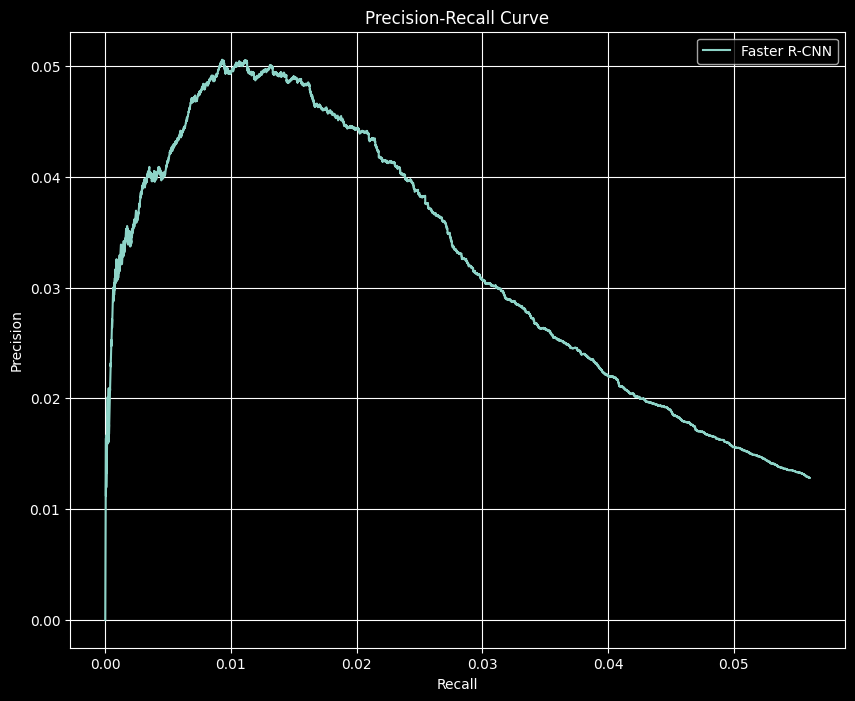

In [ ]:
# Evaluate Faster R-CNN
print("Evaluating Faster R-CNN...")
precision_rcnn, recall_rcnn, f1_rcnn = evaluate_detections(detections, targets)

print(f"\nFaster R-CNN Results:")
print(f"Precision: {precision_rcnn:.4f}")
print(f"Recall: {recall_rcnn:.4f}")
print(f"F1 Score: {f1_rcnn:.4f}")

# Plot PR curve
plt.figure(figsize=(10, 8))
precisions_rcnn, recalls_rcnn = calculate_pr_points(detections, targets)
plot_pr_curve(precisions_rcnn, recalls_rcnn, 'Faster R-CNN')
plt.show()

In [ ]:
# Diagnostic code to understand data structure
print("Checking detections and targets structure...")
print("\nFirst detection item structure:")
print(detections[0][0].keys())  # Check available keys in detections

print("\nFirst target item structure:")
print(targets[0][0].keys())  # Check available keys in targets

# Print full example
print("\nExample target:")
print(targets[0][0])

Checking detections and targets structure...

First detection item structure:
dict_keys(['boxes', 'labels', 'scores'])

First target item structure:
dict_keys(['boxes', 'labels'])

Example target:
{'boxes': tensor([[236.9800, 142.5100, 261.6800, 212.0100],
        [  7.0300, 167.7600, 156.3500, 262.6300],
        [557.2100, 209.1900, 638.5600, 287.9200],
        [358.9800, 218.0500, 414.9800, 320.8800],
        [290.6900, 218.0000, 352.5200, 316.4800],
        [413.2000, 223.0100, 443.3700, 304.3700],
        [317.4000, 219.2400, 338.9800, 230.8300],
        [412.8000, 157.6100, 465.8500, 295.6200],
        [384.4300, 172.2100, 399.5500, 207.9500],
        [512.2200, 205.7500, 526.9600, 221.7200],
        [493.1000, 174.3400, 513.3900, 282.6500],
        [604.7700, 305.8900, 619.1100, 351.6000],
        [613.2400, 308.2400, 626.1200, 354.6800],
        [447.7700, 121.1200, 461.7400, 143.0000],
        [549.0600, 309.4300, 585.7400, 399.1000],
        [350.7600, 208.8400, 362.1300, 231.